### Student Course Completion Classification Model 
#### By : Shivam Singh

In [42]:
# Import Data Manipulation Libraries
import pandas as pd
import numpy as np

# Import data visualization libaries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing filter warning libraries
import warnings
warnings.filterwarnings(action= 'ignore')

# Importing Data logging Libraries
import logging
logging.basicConfig(level=logging.INFO,
                    filename= 'model.log',
                    filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    force = True)
# Import OrderDict()
from collections import OrderedDict

# Import scikit-learn Library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler , RobustScaler , LabelEncoder
from sklearn.metrics import  classification_report ,confusion_matrix
from imblearn.over_sampling import SMOTE

# Import Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# Data Ingestion 
def data_ingestion():
    return pd.read_csv(r'C:\15Days15Project\Student-Course-Completion-Model\data\raw\Course_Completion_Prediction.csv')

df = data_ingestion()
df.head()

,Student_ID,Name,Gender,Age,Education_Level,Employment_Status,City,Device_Type,Internet_Connection_Quality,Course_ID,...,Enrollment_Date,Payment_Mode,Fee_Paid,Discount_Used,Payment_Amount,App_Usage_Percentage,Reminder_Emails_Clicked,Support_Tickets_Raised,Satisfaction_Rating,Completed
0,STU100000,Vihaan Patel,Male,19,Diploma,Student,Indore,Laptop,Medium,C102,...,01-06-2024,Scholarship,No,No,1740,49,3,4,3.5,Completed
1,STU100001,Arjun Nair,Female,17,Bachelor,Student,Delhi,Laptop,Low,C106,...,27-04-2025,Credit Card,Yes,No,6147,86,0,0,4.5,Not Completed
2,STU100002,Aditya Bhardwaj,Female,34,Master,Student,Chennai,Mobile,Medium,C101,...,20-01-2024,NetBanking,Yes,No,4280,85,1,0,5.0,Completed
3,STU100003,Krishna Singh,Female,29,Diploma,Employed,Surat,Mobile,High,C105,...,13-05-2025,UPI,Yes,No,3812,42,2,3,3.8,Completed
4,STU100004,Krishna Nair,Female,19,Master,Self-Employed,Lucknow,Laptop,Medium,C106,...,19-12-2024,Debit Card,Yes,Yes,5486,91,3,0,4.0,Completed


In [6]:
# Descriptive Stats 


def descriptive_stats():
    numerical_col = df.select_dtypes(exclude = 'object').columns
    categorica_col = df.select_dtypes(include = 'object').columns
    num_stats = []
    cat_stats = []
    data_info = []

    for i in numerical_col:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1 
        LF = Q1 - 1.5*IQR
        UF = Q3 + 1.5*IQR

        outlier_count = len(df[(df[i] < LF) | (df[i] > UF)])
        outlier_percentage = outlier_count / len(df[i]) * 100

        numerical_stats = OrderedDict({
            "Feature " : i ,
            "Q1" : Q1,
            "Q3" : Q3,
            "IQR" : IQR,
            "LF" : LF,
            "UF" : UF,
            "Mean" : df[i].mean(),
            "Median" : df[i].median(),
            "Min" : df[i].min(),
            "Max" : df[i].max(),
            "Outlier count" : outlier_count,
            "outlier percentage" : outlier_percentage,
            "standard derivation": df[i].std(),
            "variance" : df[i].var(),
            "skewness" : df[i].skew(),
            "kurtosis" : df[i].kurtosis()
        })
        num_stats.append(numerical_stats)
    numerical_stats_report = pd.DataFrame(num_stats)

    for i in categorica_col:
        categorical_stats = OrderedDict({
            "Feature" : i , 
            "Unquie count" : df[i].nunique(),
            "Value count" : df[i].value_counts(),
            "mode" : df[i].mode()
        })
        cat_stats.append(categorical_stats)
    categorical_stats_report = pd.DataFrame(cat_stats)


    for i in df.columns : 
        data1 = OrderedDict({
            "Feature" : i ,
            "Missing value" : df[i].isnull().sum(),
            "Unqiue value" : df[i].nunique(),
            "value count " : df[i].value_counts().to_dict()
        })
        data_info.append(data1)
    data_info_report = pd.DataFrame(data_info)

    return categorical_stats_report,numerical_stats_report,data_info_report

categorical_stats_report,numerical_stats_report,data_info_report = descriptive_stats()


In [7]:
# Numerical Stats 
numerical_stats_report

,Feature,Q1,Q3,IQR,LF,UF,Mean,Median,Min,Max,Outlier count,outlier percentage,standard derivation,variance,skewness,kurtosis
0,Age,21.0,30.0,9.0,7.50,43.50,25.709590,25.0,17.0,52.0,147,0.147,5.615292,3.153151e+01,0.332086,-0.365998
1,Course_Duration_Days,30.0,60.0,30.0,-15.00,105.00,51.817300,45.0,25.0,90.0,0,0.000,20.324801,4.130976e+02,0.470894,-0.823034
2,Instructor_Rating,4.3,4.6,0.3,3.85,5.05,4.444478,4.5,4.1,4.7,0,0.000,0.202631,4.105932e-02,-0.404213,-1.210576
3,Login_Frequency,3.0,6.0,3.0,-1.50,10.50,4.785380,5.0,0.0,15.0,374,0.374,1.848289,3.416172e+00,0.476268,0.266203
4,Average_Session_Duration_Min,27.0,41.0,14.0,6.00,62.00,33.878180,34.0,5.0,81.0,582,0.582,10.341964,1.069562e+02,0.019499,-0.073608
5,Video_Completion_Rate,48.5,77.5,29.0,5.00,121.00,62.174580,64.0,5.0,99.9,0,0.000,19.558126,3.825203e+02,-0.364422,-0.553852
6,Discussion_Participation,1.0,3.0,2.0,-2.00,6.00,2.329290,2.0,0.0,12.0,1366,1.366,1.591365,2.532443e+00,0.730318,0.568511
7,Time_Spent_Hours,0.5,6.2,5.7,-8.05,14.75,3.873632,2.7,0.5,25.6,1102,1.102,3.781185,1.429736e+01,1.114612,0.734894
8,Days_Since_Last_Login,1.0,9.0,8.0,-11.00,21.00,6.188860,4.0,0.0,99.0,4048,4.048,6.982047,4.874898e+01,2.295674,8.583771
9,Notifications_Checked,4.0,7.0,3.0,-0.50,11.50,5.232110,5.0,0.0,18.0,1133,1.133,2.401486,5.767133e+00,0.508308,0.315532


In [8]:
# Categorical Stats
categorical_stats_report

,Feature,Unquie count,Value count,mode
0,Student_ID,100000,Student_ID STU100000 1 STU100001 1 STU10...,0 STU100000 1 STU100001 2 ...
1,Name,300,Name Ritika Iyer 398 Arjun Joshi 387...,"0 Ritika Iyer Name: Name, dtype: object"
2,Gender,3,Gender Female 50187 Male 47819 Other ...,"0 Female Name: Gender, dtype: object"
3,Education_Level,5,Education_Level Bachelor 54956 Master ...,"0 Bachelor Name: Education_Level, dtype: ob..."
4,Employment_Status,4,Employment_Status Employed 45091 Stude...,"0 Employed Name: Employment_Status, dtype: ..."
5,City,15,City Indore 6747 Delhi 6743 Mumba...,"0 Indore Name: City, dtype: object"
6,Device_Type,3,Device_Type Mobile 60021 Laptop 35018 Ta...,"0 Mobile Name: Device_Type, dtype: object"
7,Internet_Connection_Quality,3,Internet_Connection_Quality Medium 49985 Hi...,"0 Medium Name: Internet_Connection_Quality,..."
8,Course_ID,8,Course_ID C101 16807 C102 15465 C103 ...,"0 C101 Name: Course_ID, dtype: object"
9,Course_Name,8,Course_Name Python Basics 16...,"0 Python Basics Name: Course_Name, dtype: o..."


In [9]:
# Data Info 
data_info_report

,Feature,Missing value,Unqiue value,value count
0,Student_ID,0,100000,"{'STU100000': 1, 'STU100001': 1, 'STU100002': ..."
1,Name,0,300,"{'Ritika Iyer': 398, 'Arjun Joshi': 387, 'Saks..."
2,Gender,0,3,"{'Female': 50187, 'Male': 47819, 'Other': 1994}"
3,Age,0,34,"{17: 9145, 25: 6649, 26: 6616, 24: 6460, 27: 6..."
4,Education_Level,0,5,"{'Bachelor': 54956, 'Master': 21859, 'HighScho..."
5,Employment_Status,0,4,"{'Employed': 45091, 'Student': 44929, 'Self-Em..."
6,City,0,15,"{'Indore': 6747, 'Delhi': 6743, 'Mumbai': 6731..."
7,Device_Type,0,3,"{'Mobile': 60021, 'Laptop': 35018, 'Tablet': 4..."
8,Internet_Connection_Quality,0,3,"{'Medium': 49985, 'High': 35002, 'Low': 15013}"
9,Course_ID,0,8,"{'C101': 16807, 'C102': 15465, 'C103': 12702, ..."


### Feature Engineering


In [24]:
df["Enrollment_Date"] = pd.to_datetime(df["Enrollment_Date"], errors="coerce")

df["enroll_year"] = df["Enrollment_Date"].dt.year
df["enroll_month"] = df["Enrollment_Date"].dt.month

# Drop original date (raw dates not ML-friendly)
df.drop(columns=["Enrollment_Date"], inplace=True)

In [25]:
df["Inactive_Days_Bucket"] = pd.cut(
        df["Days_Since_Last_Login"],
        bins=[-1, 7, 30, 90, np.inf],
        labels=["Active", "Low", "Medium", "High"]
    )

In [26]:
df["Course_Length"] = pd.cut(
        df["Course_Duration_Days"],
        bins=[0, 30, 90, 180, np.inf],
        labels=["Short", "Medium", "Long", "Very_Long"]
    )

In [27]:
df["Payment_Level"] = pd.qcut(
        df["Payment_Amount"],
        q=3,
        labels=["Low", "Medium", "High"]
    )

In [28]:
df["Engagement_Score"] = (
        df["Login_Frequency"] * 0.25 +
        df["Average_Session_Duration_Min"] * 0.25 +
        df["Video_Completion_Rate"] * 0.30 +
        df["Discussion_Participation"] * 0.20
    )

In [29]:
df["Performance_Score"] = (
        df["Quiz_Score_Avg"] * 0.4 +
        df["Project_Grade"] * 0.6
    )

In [31]:
drop_cols = [
        "Payment_Amount",
        "Course_Duration_Days",
        "Days_Since_Last_Login"
    ]
df.drop(columns=drop_cols, inplace=True)

In [32]:
df.head()

,Student_ID,Name,Gender,Age,Education_Level,Employment_Status,City,Device_Type,Internet_Connection_Quality,Course_ID,...,Support_Tickets_Raised,Satisfaction_Rating,Completed,enroll_year,enroll_month,Inactive_Days_Bucket,Course_Length,Payment_Level,Engagement_Score,Performance_Score
0,STU100000,Vihaan Patel,Male,19,Diploma,Student,Indore,Laptop,Medium,C102,...,4,3.5,Completed,2024.0,1.0,Active,Medium,Low,25.15,75.08
1,STU100001,Arjun Nair,Female,17,Bachelor,Student,Delhi,Laptop,Low,C106,...,0,4.5,Not Completed,NaN,NaN,Active,Medium,High,35.88,56.86
2,STU100002,Aditya Bhardwaj,Female,34,Master,Student,Chennai,Mobile,Medium,C101,...,0,5.0,Completed,NaN,NaN,Low,Medium,Medium,26.78,92.74
3,STU100003,Krishna Singh,Female,29,Diploma,Employed,Surat,Mobile,High,C105,...,3,3.8,Completed,NaN,NaN,Low,Medium,Medium,26.44,54.48
4,STU100004,Krishna Nair,Female,19,Master,Self-Employed,Lucknow,Laptop,Medium,C106,...,0,4.0,Completed,NaN,NaN,Active,Medium,High,35.62,89.72


In [37]:
df.drop(columns=['Student_ID' , 'Name' , 'Course_ID' , 'Course_Name' ],inplace= True)

In [34]:
df.columns

Index(['Student_ID', 'Name', 'Gender', 'Age', 'Education_Level',
       'Employment_Status', 'City', 'Device_Type',
       'Internet_Connection_Quality', 'Course_ID', 'Course_Name', 'Category',
       'Course_Level', 'Instructor_Rating', 'Login_Frequency',
       'Average_Session_Duration_Min', 'Video_Completion_Rate',
       'Discussion_Participation', 'Time_Spent_Hours', 'Notifications_Checked',
       'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed',
       'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade',
       'Progress_Percentage', 'Rewatch_Count', 'Payment_Mode', 'Fee_Paid',
       'Discount_Used', 'App_Usage_Percentage', 'Reminder_Emails_Clicked',
       'Support_Tickets_Raised', 'Satisfaction_Rating', 'Completed',
       'enroll_year', 'enroll_month', 'Inactive_Days_Bucket', 'Course_Length',
       'Payment_Level', 'Engagement_Score', 'Performance_Score'],
      dtype='object')

### EDA


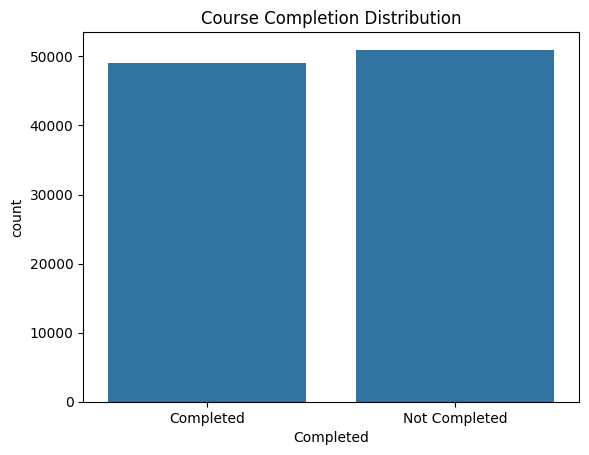

In [10]:
sns.countplot(x="Completed", data=df)
plt.title("Course Completion Distribution")
plt.show()

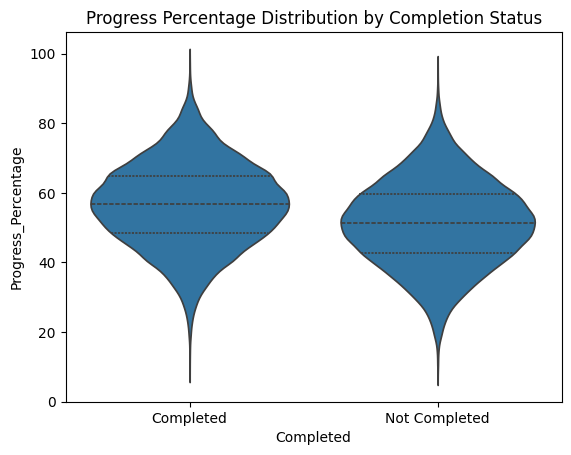

In [16]:
sns.violinplot(x="Completed", y="Progress_Percentage", data=df, inner="quartile")
plt.title("Progress Percentage Distribution by Completion Status")
plt.show()

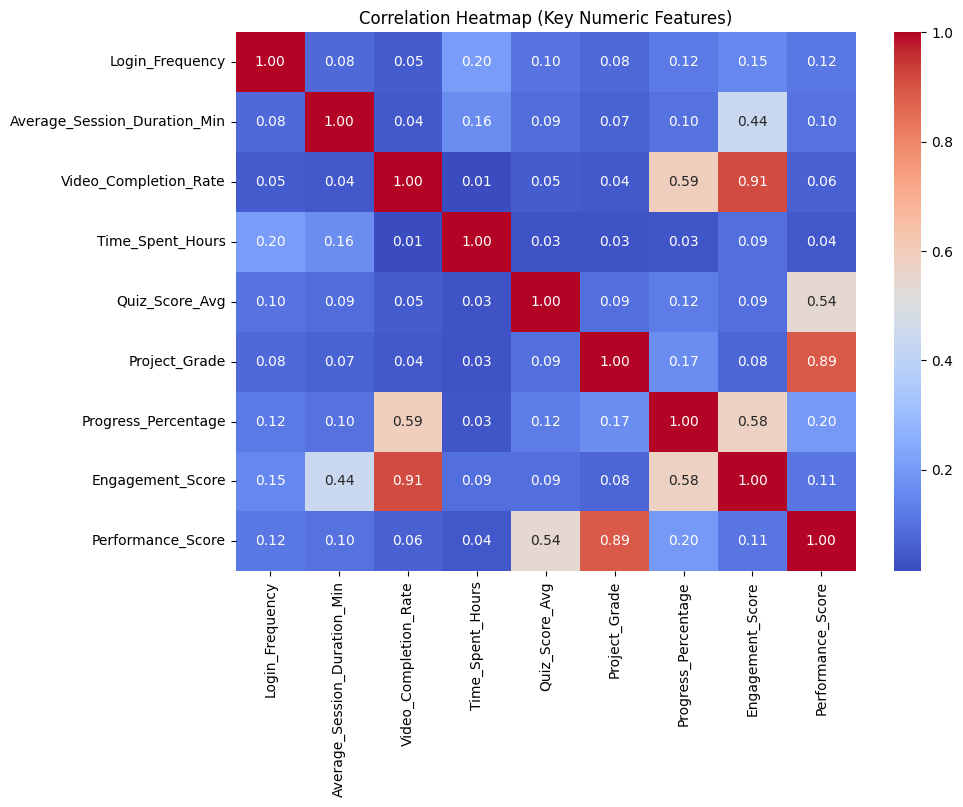

In [38]:
num_cols = [
    "Login_Frequency",
    "Average_Session_Duration_Min",
    "Video_Completion_Rate",
    "Time_Spent_Hours",
    "Quiz_Score_Avg",
    "Project_Grade",
    "Progress_Percentage",
    "Engagement_Score",
    "Performance_Score"
]

plt.figure(figsize=(10,7))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Key Numeric Features)")
plt.show()


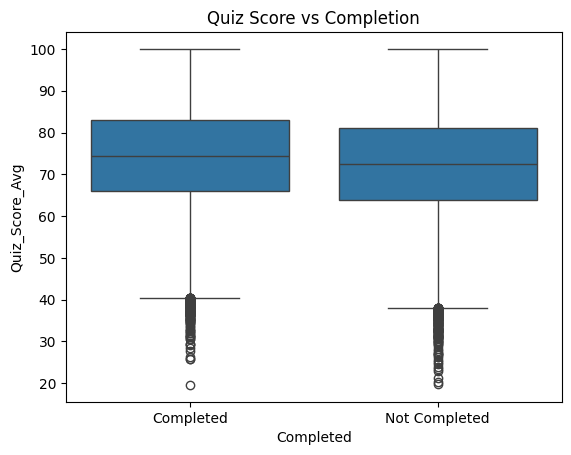

In [13]:
sns.boxplot(x="Completed", y="Quiz_Score_Avg", data=df)
plt.title("Quiz Score vs Completion")
plt.show()

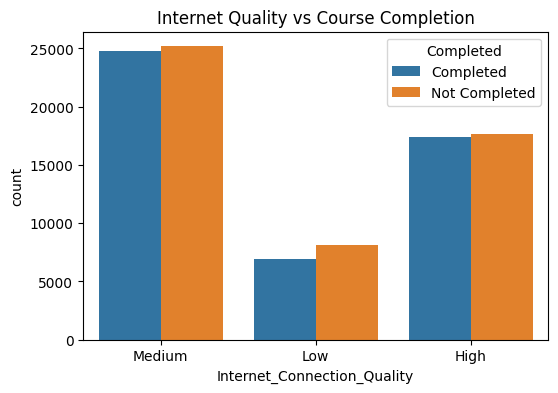

In [39]:
plt.figure(figsize=(6,4))
sns.countplot(x="Internet_Connection_Quality", hue="Completed", data=df)
plt.title("Internet Quality vs Course Completion")
plt.show()


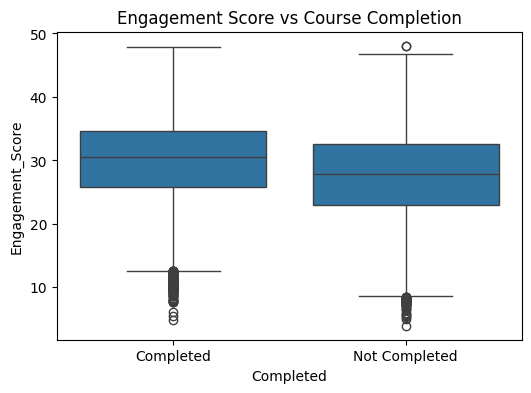

In [40]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Completed", y="Engagement_Score", data=df)
plt.title("Engagement Score vs Course Completion")
plt.show()


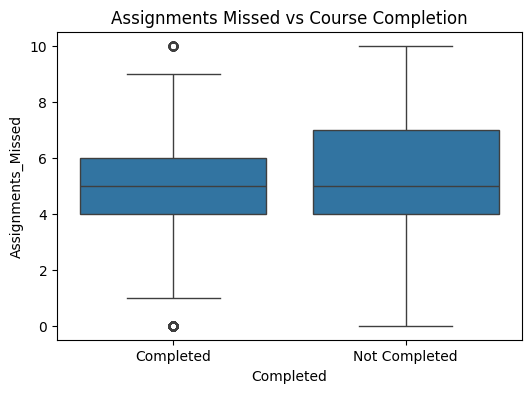

In [41]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Completed", y="Assignments_Missed", data=df)
plt.title("Assignments Missed vs Course Completion")
plt.show()


Data Insights:
- complete is the target column
- This is multivariate \ classification model

### Different Model Testing

In [57]:
# Data Preprocessing
def data_preprocessing(df):
  X = df.drop(columns='Completed', axis= 1)
  y = df['Completed']

  # step 1 : Use train test split
  X_train,X_test ,y_train ,y_test = train_test_split(X , y ,
                                                      test_size= 0.3 ,
                                                     random_state= 7)

  # step 2 : Use Encoding Technique
  le = LabelEncoder()
  for i in X_train.select_dtypes(include = 'object').columns:
    X_train[i] = le.fit_transform(X_train[i])
    X_test[i] = le.transform(X_test[i])

  # step 3 : Scaling Technique : RobustScaler()
  sc = RobustScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  # step 4 : Smote Technique : SMOTE technique
  smote = SMOTE()
  X_train,y_train = smote.fit_resample(X_train,y_train)

  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = data_preprocessing(df)



ValueError: could not convert string to float: 'Active'

In [ ]:
# Model Building
def model_building(X_train,X_test,y_train,y_test):
  models = {
      'Logistic Regression': LogisticRegression(),
      'Decision Tree': DecisionTreeClassifier(),
      'Random Forest': RandomForestClassifier(),
      'AdaBoost': AdaBoostClassifier(),
      'Gradient Boosting': GradientBoostingClassifier(),
      'Support Vector Machine': SVC(),
  }

  model_performance = []
  for model_name, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

  report = classification_report(y_test,y_pred)

  report = OrderedDict({
      'Model_Name': model_name,
      'Accuracy_Score': accuracy_score(y_test,y_pred),
      'Confusion_Matrix': confusion_matrix(y_test,y_pred),
      'Classification_Report': report})

  model_performance.append(report)

  model_performance = pd.DataFrame(model_performance)
  return model_performance

In [56]:
model_performance = model_building(X_train,X_test,y_train,y_test)

NameError: name 'X_train' is not defined